In [1]:
%%capture
!pip install /kaggle/input/facenet-pytorch-vggface2/facenet_pytorch-2.2.7-py3-none-any.whl
!pip install /kaggle/input/dlibpkg/dlib-19.19.0
!pip install /kaggle/input/mtcnn-package/mtcnn-0.1.0-py3-none-any.whl

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import torch
from tqdm.notebook import tqdm
import time

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


In [3]:
sample = './input/deepfake-detection-challenge/train_sample_videos/aagfhgtpmv.mp4'

reader = cv2.VideoCapture(sample)
images_1080_1920 = []
images_720_1280 = []
images_540_960 = []
for i in tqdm(range(int(reader.get(cv2.CAP_PROP_FRAME_COUNT)))):
    _, image = reader.read()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images_1080_1920.append(image)
    images_720_1280.append(cv2.resize(image, (1280, 720)))
    images_540_960.append(cv2.resize(image, (960, 540)))
reader.release()

images_1080_1920 = np.stack(images_1080_1920)
images_720_1280 = np.stack(images_720_1280)
images_540_960 = np.stack(images_540_960)

print('Shapes:')
print(images_1080_1920.shape)
print(images_720_1280.shape)
print(images_540_960.shape)

  0%|          | 0/300 [00:00<?, ?it/s]

Shapes:
(300, 1080, 1920, 3)
(300, 720, 1280, 3)
(300, 540, 960, 3)


In [4]:
def plot_faces(images, figsize=(10.8/2, 19.2/2)):
    shape = images[0].shape
    images = images[np.linspace(0, len(images)-1, 16).astype(int)]
    im_plot = []
    for i in range(0, 16, 4):
        im_plot.append(np.concatenate(images[i:i+4], axis=0))
    im_plot = np.concatenate(im_plot, axis=1)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(im_plot)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    ax.grid(False)
    fig.tight_layout()

def timer(detector, detect_fn, images, *args):
    start = time.time()
    faces = detect_fn(detector, images, *args)
    elapsed = time.time() - start
    print(f', {elapsed:.3f} seconds')
    return faces, elapsed

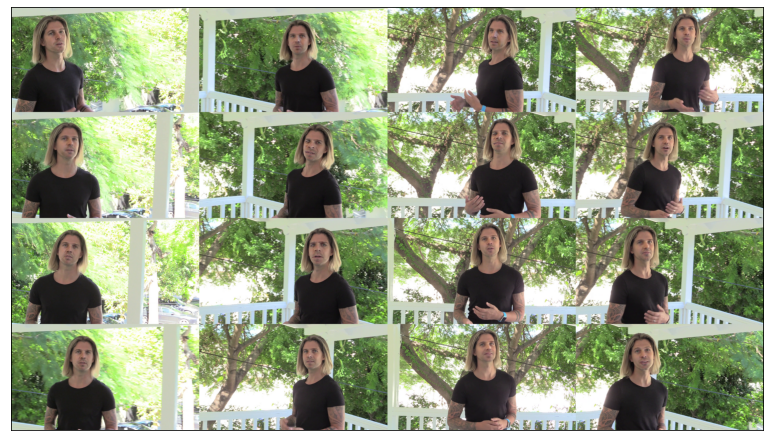

In [5]:
plot_faces(images_540_960, figsize=(10.8, 19.2))

facenet-pytorch package

In [15]:
from facenet_pytorch import MTCNN
detector = MTCNN(device=device, post_process=False)

def detect_facenet_pytorch(detector, images, batch_size):
    faces = []
    for lb in np.arange(0, len(images), batch_size):
        imgs = [img for img in images[lb:lb+batch_size]]
        faces.extend(detector(imgs))
    return faces

times_facenet_pytorch = []    # batched
times_facenet_pytorch_nb = [] # non-batched

Detecting faces in 540x960 framesC:\Users\alscj\anaconda3\envs\Torch\lib\site-packages\facenet_pytorch\models\utils\detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
C:\Users\alscj\anaconda3\envs\Torch\lib\site-packages\facenet_pytorch\models\mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
C:\Users\alscj\anaconda3\envs\Torch\lib\site-packages\facenet_pytorch\models\mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray f

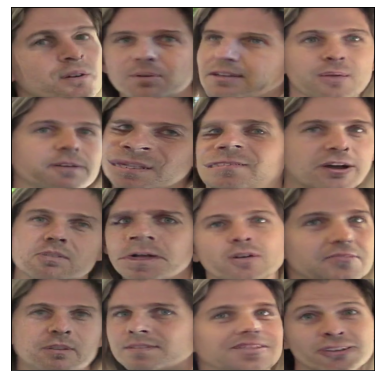

In [17]:
print('Detecting faces in 540x960 frames', end='')
_, elapsed = timer(detector, detect_facenet_pytorch, images_540_960, 30)
times_facenet_pytorch.append(elapsed)

print('Detecting faces in 720x1280 frames', end='')
_, elapsed = timer(detector, detect_facenet_pytorch, images_720_1280, 20)
times_facenet_pytorch.append(elapsed)

print('Detecting faces in 1080x1920 frames', end='')
faces, elapsed = timer(detector, detect_facenet_pytorch, images_1080_1920, 10)
times_facenet_pytorch.append(elapsed)

plot_faces(torch.stack(faces).permute(0, 2, 3, 1).int().numpy())

In [ ]:
# Cuda out of memory => batch size 줄이자

The facenet-pytorch package (non-batched

In [19]:
print('Detecting faces in 540x960 frames', end='')
_, elapsed = timer(detector, detect_facenet_pytorch, images_540_960, 1)
times_facenet_pytorch_nb.append(elapsed)

print('Detecting faces in 720x1280 frames', end='')
_, elapsed = timer(detector, detect_facenet_pytorch, images_720_1280, 1)
times_facenet_pytorch_nb.append(elapsed)

print('Detecting faces in 1080x1920 frames', end='')
faces, elapsed = timer(detector, detect_facenet_pytorch, images_1080_1920, 1)
times_facenet_pytorch_nb.append(elapsed)

Detecting faces in 540x960 frames, 25.360 seconds
Detecting faces in 720x1280 frames, 36.321 seconds
Detecting faces in 1080x1920 frames, 53.127 seconds


In [11]:
del detector
torch.cuda.empty_cache()

The dlib package

In [6]:
from dlib import get_frontal_face_detector
detector = get_frontal_face_detector()

def detect_dlib(detector, images):
    faces = []
    for image in images:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        boxes = detector(image_gray)
        box = boxes[0]
        face = image[box.top():box.bottom(), box.left():box.right()]
        faces.append(face)
    return faces

times_dlib = []

Detecting faces in 540x960 frames, 16.458 seconds
Detecting faces in 720x1280 frames, 30.075 seconds
Detecting faces in 1080x1920 frames, 73.093 seconds


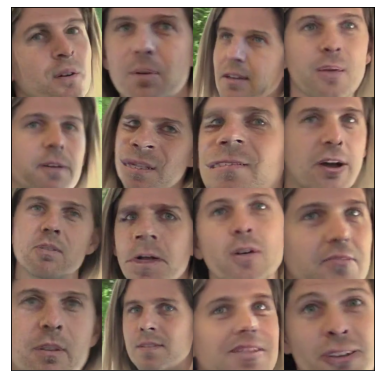

In [7]:
print('Detecting faces in 540x960 frames', end='')
_, elapsed = timer(detector, detect_dlib, images_540_960)
times_dlib.append(elapsed)

print('Detecting faces in 720x1280 frames', end='')
_, elapsed = timer(detector, detect_dlib, images_720_1280)
times_dlib.append(elapsed)

print('Detecting faces in 1080x1920 frames', end='')
faces, elapsed = timer(detector, detect_dlib, images_1080_1920)
times_dlib.append(elapsed)

plot_faces(np.stack([cv2.resize(f, (160, 160)) for f in faces]))

In [8]:
del detector
torch.cuda.empty_cache()

The mtcnn package

In [11]:
from mtcnn import MTCNN
detector = MTCNN()

def detect_mtcnn(detector, images):
    faces = []
    for image in images:
        boxes = detector.detect_faces(image)
        box = boxes[0]['box']
        face = image[box[1]:box[3]+box[1], box[0]:box[2]+box[0]]
        faces.append(face)
    return faces

times_mtcnn = []

Detecting faces in 540x960 frames, 196.425 seconds
Detecting faces in 720x1280 frames, 224.188 seconds
Detecting faces in 1080x1920 frames, 346.217 seconds


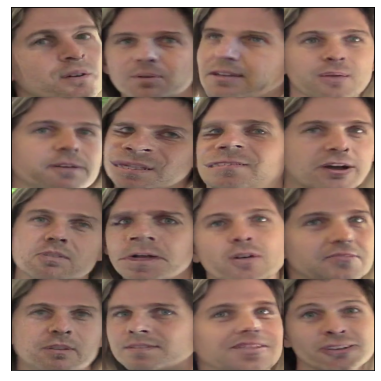

In [12]:
print('Detecting faces in 540x960 frames', end='')
_, elapsed = timer(detector, detect_mtcnn, images_540_960)
times_mtcnn.append(elapsed)

print('Detecting faces in 720x1280 frames', end='')
_, elapsed = timer(detector, detect_mtcnn, images_720_1280)
times_mtcnn.append(elapsed)

print('Detecting faces in 1080x1920 frames', end='')
faces, elapsed = timer(detector, detect_mtcnn, images_1080_1920)
times_mtcnn.append(elapsed)

plot_faces(np.stack([cv2.resize(face, (160, 160)) for face in faces]))

In [13]:
del detector
torch.cuda.empty_cache()

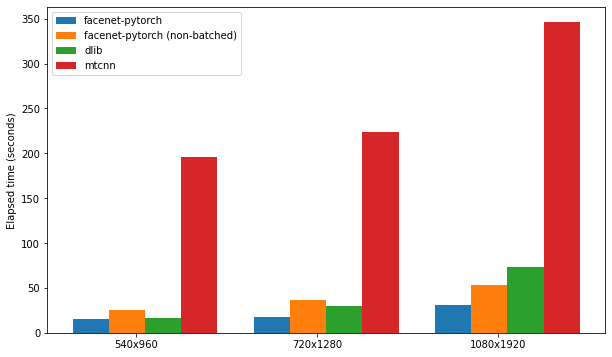

In [20]:
fig, ax = plt.subplots(figsize=(10,6))

pos = np.arange(3)
plt.bar(pos, times_facenet_pytorch, 0.2, label='facenet-pytorch')
plt.bar(pos + 0.2, times_facenet_pytorch_nb, 0.2, label='facenet-pytorch (non-batched)')
plt.bar(pos + 0.4, times_dlib, 0.2, label='dlib')
plt.bar(pos + 0.6, times_mtcnn, 0.2, label='mtcnn')

ax.set_ylabel('Elapsed time (seconds)')
ax.set_xticks(pos + 0.25)
ax.set_xticklabels(['540x960', '720x1280', '1080x1920'])
plt.legend();